In [188]:
from astropy.io import fits
from astropy import units as u 
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs as a
from scipy.io import readsav
from sunpy.coordinates import frames
import numpy as np
import pandas as pd
from sunpy.time import parse_time
from astropy.visualization import ImageNormalize, SqrtStretch
from matplotlib import colors

In [3]:
files = "/Users/laura.hayes/lofar_stix/nrh_data/nrh2_1509_h70_20221111_111000c05_b.fts"

In [4]:
aa = fits.open(files)

In [115]:
aa[1].header

XTENSION= 'BINTABLE'           /                                                
BITPIX  =                    8 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =               131080 /4 + 4 + ndim*ndim*4 + ndim*ndim*4               
NAXIS2  =                 3000 / number of rows                                 
DATE-OBS= '2022-11-11'         /                                                
TIM_STR = '11:10:00:600'       /                                                
TIM_END = '11:59:59:600'       /                                                
FREQ    =              150.900 /                                                
FREQUNIT=                    6 / in MHz                                         
HMER    = '11:35:13.57'        /heure du meridien                               
DECL    = '-17D-28M-59.-80'    /declinaison en degres                           
UV_COV_A= 'NO      '        

In [15]:
tstart = aa[0].header["DATE_OBS"]
tend = aa[0].header["DATE_END"]

In [16]:
tstart, tend

('2022-11-11T11:10:00.600Z', '2022-11-11T11:59:59.600Z')

In [18]:
res = Fido.search(a.Time(tstart, tend), a.Instrument("AIA"), 
                  a.Wavelength(171*u.angstrom))

In [24]:
ff = Fido.fetch(res, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/250 [00:00<?, ?file/s]

5/0 files failed to download. Please check `.errors` for details


In [10]:
aa[1].data.dtype.names

('TIME', 'NUMIM', 'STOKESI', 'STOKESV')

In [13]:
aa[1].data["STOKESI"].shape

(3000, 128, 128)

In [92]:
nrh = readsav("/Users/laura.hayes/lofar_stix/nrh_data/map0.sav", python_dict=True)

In [116]:
b = {name:nrh["map0_hdr"][name][0] for name in nrh["map0_hdr"].dtype.names}

In [118]:
map_data = nrh["map0_data"]

In [119]:
b["CDELT2"]

30.351173400878906

In [120]:
b["FREQ"]

150.9

In [121]:
ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                     frame=frames.Helioprojective(observer="earth", obstime=b["DATE_OBS"]), 
                     )

header = sunpy.map.make_fitswcs_header(map_data, 
                                       ref_coord, 
                                       reference_pixel=[int(b["CRPIX1"])-1, int(b["CRPIX2"])-1]*u.pixel, 
                                       scale=[float(b["CDELT1"]), float(b["CDELT2"])]*u.arcsec/u.pixel, 
                                       wavelength=float(b["FREQ"])*u.MHz)

In [122]:
nrh_map = sunpy.map.Map(map_data, header)

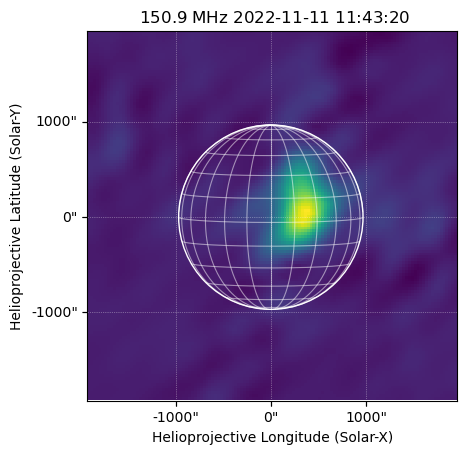

In [124]:
nrh_map.plot(cmap="viridis")
nrh_map.draw_limb(color='w')
nrh_map.draw_grid(color='w')
plt.savefig("first_example.png", dpi=300)

In [100]:
aia_map = sunpy.map.Map("./AIA/aia_lev1_171a_2022_11_11t11_43_21_35z_image_lev1.fits")

In [106]:
with frames.Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    nrh_map2 = nrh_map.reproject_to(aia_map.wcs)

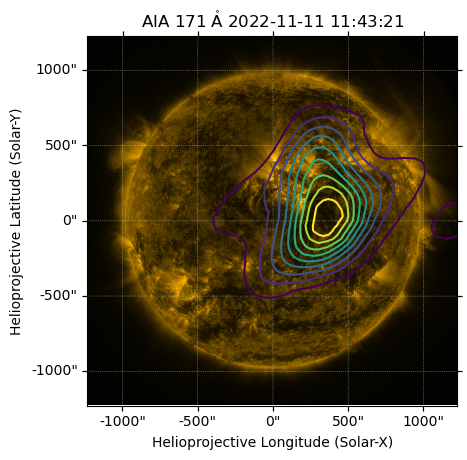

In [114]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
aia_map.plot()
nrh_map2.draw_contours(levels=np.arange(10, 100, 10)*u.percent)
plt.savefig("first_example_w_aia.png", dpi=300)

In [125]:
all_maps = readsav("/Users/laura.hayes/lofar_stix/nrh_data/all_maps.sav")

In [127]:
all_data = all_maps["nrh_data"]
all_headers = all_maps["nrh_hdr"]

In [130]:
all_headers[0]["CRPIX1"]

64

In [140]:
def make_map_header(map_data, hdr):
    ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                     frame=frames.Helioprojective(observer="earth", obstime=hdr["DATE_OBS"]), 
                     )

    header = sunpy.map.make_fitswcs_header(map_data, 
                                           ref_coord, 
                                           reference_pixel=[hdr["CRPIX1"]-1, hdr["CRPIX2"]-1]*u.pixel, 
                                           scale=[hdr["CDELT1"], hdr["CDELT2"]]*u.arcsec/u.pixel, 
                                           wavelength=hdr["FREQ"]*u.MHz)
    
    nrh_map = sunpy.map.Map(map_data, header)
    nrh_map.plot_settings["cmap"] = "viridis"
    return nrh_map

In [141]:
map1 = make_map_header(all_data[100], all_headers[100])

In [145]:
all_data.shape

(3000, 128, 128)

In [155]:
all_times = pd.to_datetime(all_headers["DATE_OBS"].astype(str))

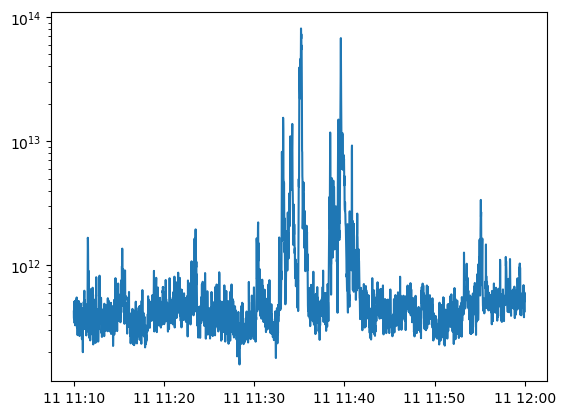

In [158]:
plt.plot(all_times, np.sum(all_data, axis=(1, 2)))
plt.yscale("log")

(<matplotlib.patches.Circle at 0x7f776d23f730>, None)

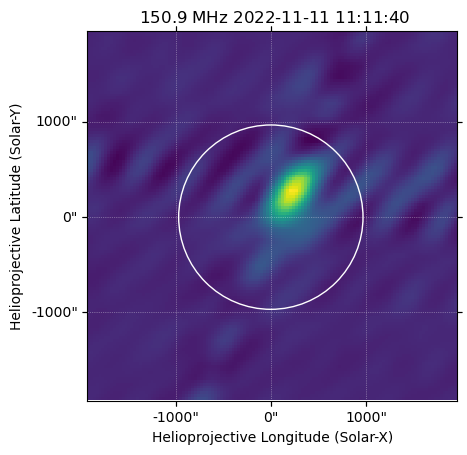

In [143]:
map1.plot()
map1.draw_limb()

In [168]:
all_times[1200]

Timestamp('2022-11-11 11:30:00.600000+0000', tz='UTC')

In [210]:
maps = []
for i in range(1200, 2999, 4):
    n_map = make_map_header(all_data[i], all_headers[i])
    maps.append(n_map)

In [211]:
maps = sunpy.map.Map(maps, sequence=True)

In [212]:
%matplotlib notebook

<IPython.core.display.Javascript object>


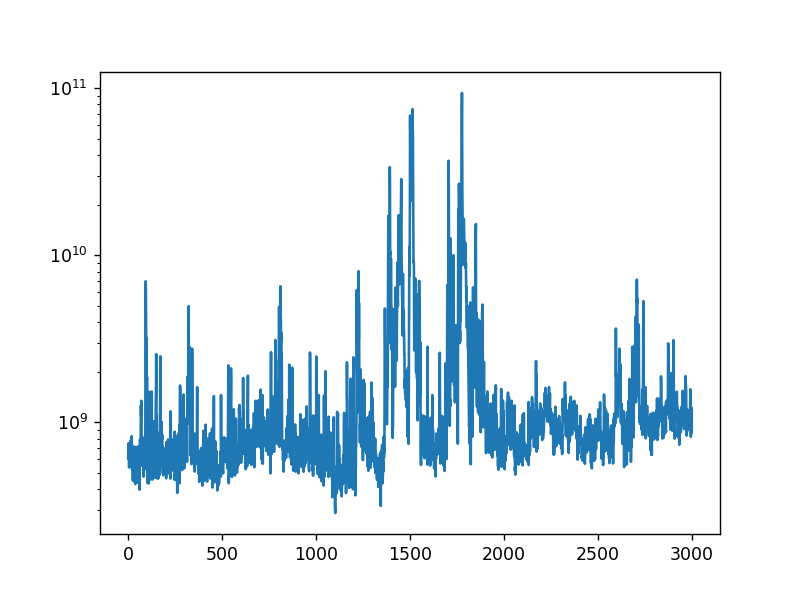

In [213]:
fig = plt.figure()
plt.plot(np.max(all_data, axis=(1, 2)))
#plt.plot(np.min(all_data, axis=(1, 2)))
plt.yscale("log")

In [215]:
np.argmax(np.max(all_data, axis=(1, 2)))

1776

<IPython.core.display.Javascript object>


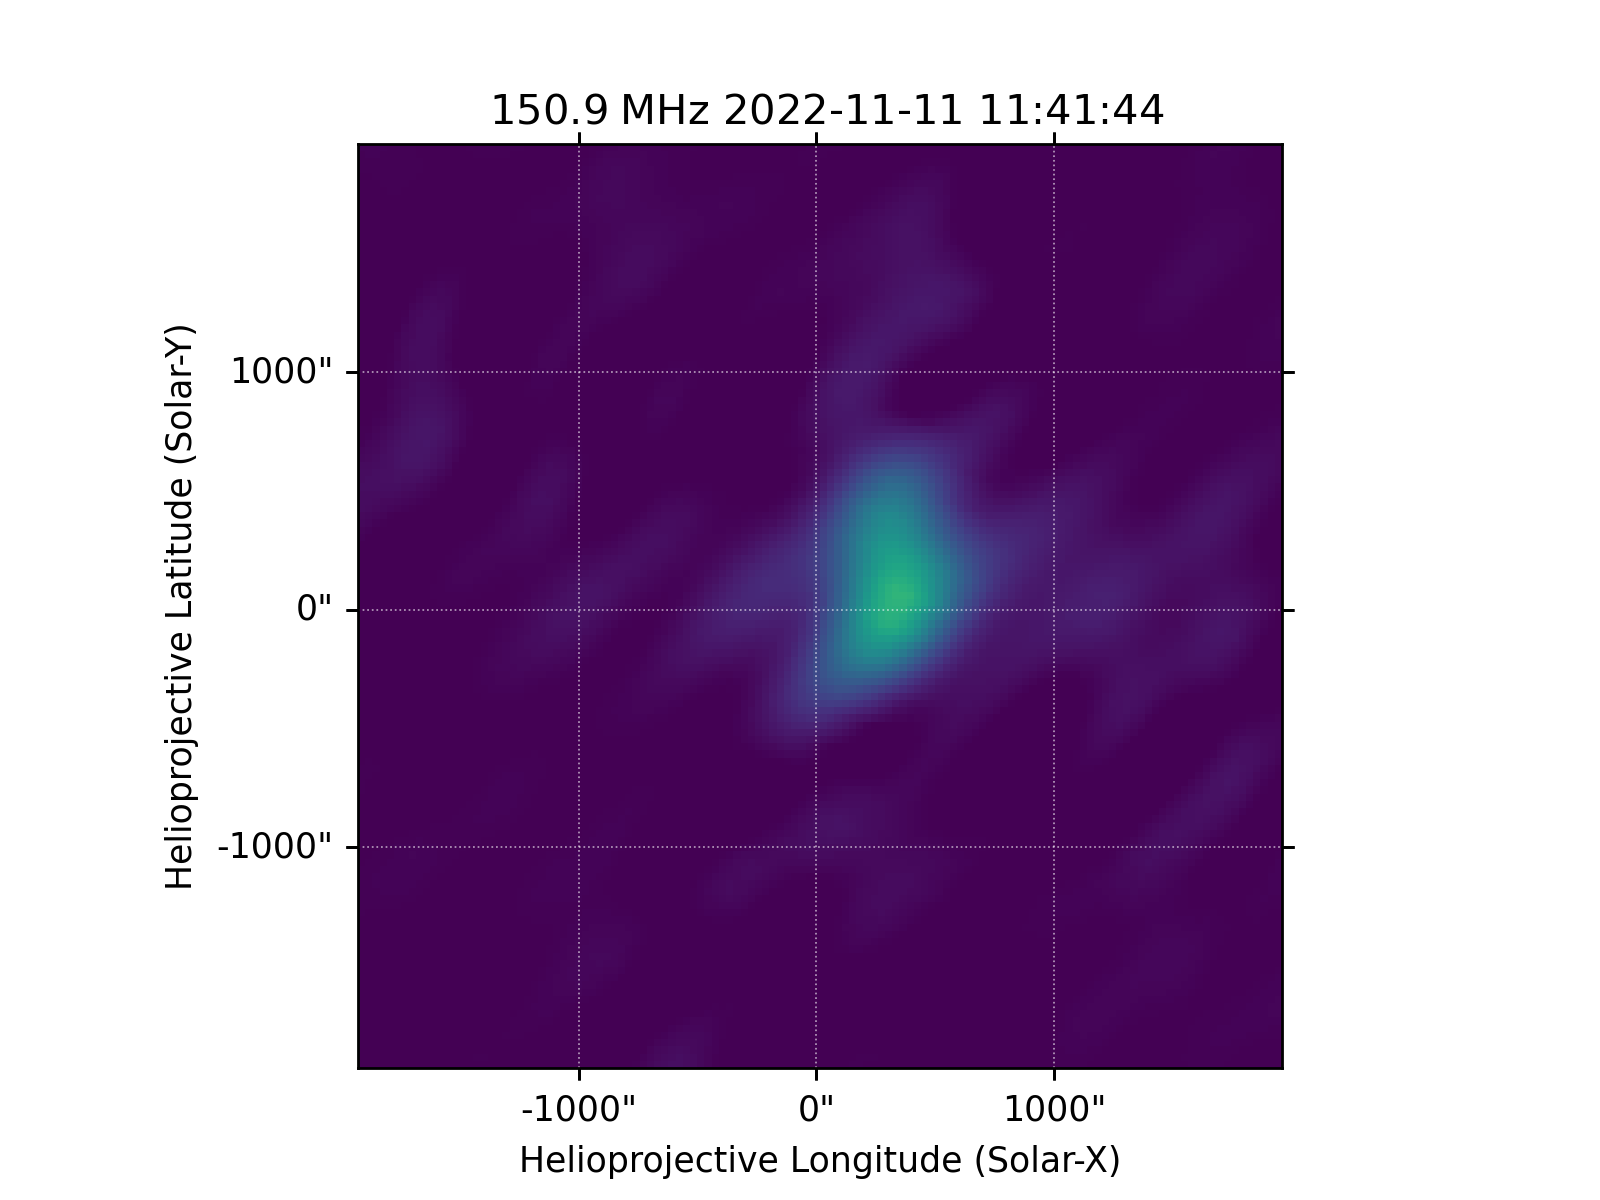

In [227]:
fig = plt.figure()
maps[176].plot(vmin=0.1, vmax=1e9)


<IPython.core.display.Javascript object>


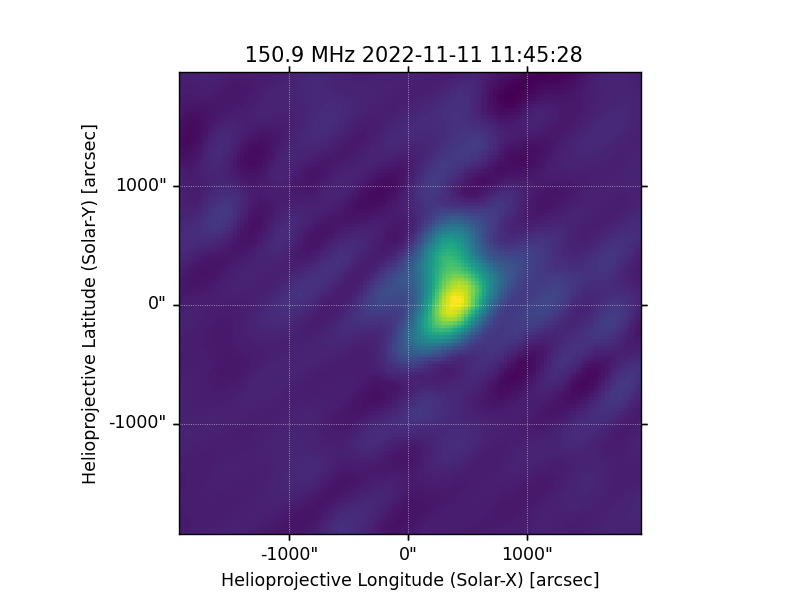

In [217]:
plt.figure()
ani = maps.plot(vmin=0.1, vmax=1e9)

plt.show()

In [221]:
file = "/Users/laura.hayes/lofar_stix/nrh_data/nrh_maps_221111_111000_115959_150.sav"
nrh_data = readsav(file, python_dict=True)

In [226]:
nrh_data["nrh_hdr"]

rec.array([(b'BINTABLE', -32, 2, 128, 128, b'2022-11-11', 30.3511734, 30.3511734, b'11:10:00:600', b'11:59:59:600', b'2022-11-11T11:10:00.600Z', 150.9, 6, b'11:35:13.57', b'-17D-28M-59.-80', b'NO', b'NO', b'NONE', b'NONE', 64, 64, 32., 1., 1., b'TB', 0, 1, 4, b'1J', b'TIME', 27032, 1000, 1, b'1J', b'NUMIM', 0, 100, 1, b'16384E', b'STOKESI', b'(128,128)', b'16384E', b'STOKESV', b'(128,128)', 9.37284e+10, -1.2636e+10, b'VERSION', b'T_INTEG', b'N_PERIOD', b'MODE_INTERPOL', b'ROT_P', b'NP', b'LARG', b'T_B', b'I_AFFICH_LOBE', b'I_MUL_POL', b'IE0_EW', b'IE0_NS', b'IE1_EW', b'IE2_EW', b'IE2_NS', b'INS45_EW', b'INS45_NS', b'I_REDOND', b'SUPPRESS_ANT', b'I_CON_CAL', b'I_CORR_POS_ANT', b'I_RECALIB', b'I_SOURCE_CAL', b'H_CAL', b'CH_COR', b'PHI_EW_NS', b'PHI_W_E', b'I_CORR_G', b'G_FLAG', b'G_FLAG', b'G_FLAG', b'G_FLAG', b'G_FLAG', b'G_FLAG', b'G_AMP', b'G_AMP', b'G_AMP', b'G_AMP', b'G_AMP', b'G_AMP', b'G_AMP', b'G_AMP', b'G_AMP', b'G_AMP', b'G_AMP', b'G_AMP', b'G_PHI', b'G_PHI', b'G_PHI', b'G_PHI'